In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
sys.path.append(os.path.realpath('..'))

In [3]:
import numpy as np
import scipy as sp
import pandas as pd
import plotly.express as ex
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from copy import deepcopy
import cache_magic

from IPython.display import display
import ipywidgets.widgets as widgets

from tracking_v2.target import ConstantVelocityTarget, SingerTarget
from tracking_v2.kalman import LinearKalmanFilter
from tracking_v2.motion import ConstantVelocityModel, ConstantAccelerationModel, SingerAccelerationModel
from tracking_v2.sensor import GeometricSensor
from tracking_v2.evaluation import Runner, run_many, evaluate_many, plot_nees, evaluate_nees, \
                                   plot_error, evaluate_runner, plot_2d, plot_3d

from tracking.util import to_df

%cache magic is now registered in ipython


In [4]:
def two_columns(fig1, fig2):
    output1 = widgets.Output(layout={'width': '50%'})
    with output1:
        display(fig1)

    output2 = widgets.Output(layout={'width': '50%'})
    with output2:
        display(fig2)
    
    column_layout = widgets.HBox([output1, output2])
    display(column_layout)

In [5]:
target = ConstantVelocityTarget()

In [6]:
def _drift_one(q, target):
    motion = ConstantVelocityModel(q)
    kf = LinearKalmanFilter(motion, [[1, 0, 0, 0, 0, 0],
                                     [0, 1, 0, 0, 0, 0],
                                     [0, 0, 1, 0, 0, 0]])

    sensor = GeometricSensor(seed=8)
    r = Runner(target, sensor, kf)
    r.run_many(1, 500)
    return r

In [7]:
def _plot_error_one(runner):
    tm  = np.arange(runner.n-100).reshape((runner.n-100, -1))
    err = np.hstack((tm, np.abs(runner.one_x_hat[100:,:3,0] - runner.truth[101:,:3])))
    err = to_df(err, columns=['time', 'x', 'y', 'z']).melt(['time'], ['x', 'y', 'z'], 'dim', 'error')
    return ex.line(err, x='time', y='error', facet_row='dim')

In [8]:
def _plot_nees_one(runner):
    nees = evaluate_nees(runner.one_x_hat[:, :3, :], runner.one_P_hat[:, :3, :3], runner.truth[1:, :3])
    err = np.asarray((np.arange(runner.n-100), nees.scores[100:])).T
    err = to_df(err, columns=['time', 'nees'])
    fig = ex.line(err, x='time', y='nees')
    
    ci = sp.stats.chi2.ppf([0.025, 0.975], nees.dim)
    fig.add_hline(y=ci[0], line_width=.5, line_dash="dash", line_color="red")
    fig.add_hline(y=ci[1], line_width=.5, line_dash="dash", line_color="red")

    return fig

In [9]:
def _drift_many(Q, target, m=100):
    motion = ConstantVelocityModel(Q)
    kf = LinearKalmanFilter(motion, [[1, 0, 0, 0, 0, 0],
                                     [0, 1, 0, 0, 0, 0],
                                     [0, 0, 1, 0, 0, 0]])
    sensor = GeometricSensor()
    r = Runner(target, sensor, kf)
    r.run_many(m, 500)
    return r

In [10]:
def _plot_nees_many(runner, skip=100):
    nees = evaluate_nees(runner.many_x_hat[:, :, :3, :], runner.many_P_hat[:, :, :3, :3], runner.truth[1:, :3])
    err = np.asarray((np.arange(runner.n-skip), nees.scores[:,skip:].mean(axis=0))).T
    err = to_df(err, columns=['time', 'nees'])
    fig = ex.line(err, x='time', y='nees')
    
    ci = sp.stats.chi2.ppf([0.025, 0.975], runner.m * nees.dim) / runner.m
    fig.add_hline(y=ci[0], line_width=.5, line_dash="dash", line_color="red")
    fig.add_hline(y=ci[1], line_width=.5, line_dash="dash", line_color="red")

    return fig

In [11]:
def _plot_error_many(runner):
    tm  = np.arange(runner.n-100)
    err = np.linalg.norm(runner.many_x_hat[:,100:,:3,0] - runner.truth[101:,:3], axis=2)
    
    avg = np.array((tm, err.mean(axis=0))).T
    avg = to_df(avg, columns=['time', 'err'])
    avg['type'] = 'avg'
    
    low = np.array((tm, np.quantile(err, .025, axis=0))).T
    low = to_df(low, columns=['time', 'err'])
    low['type'] = '.025'
    
    upp = np.array((tm, np.quantile(err, .975, axis=0))).T
    upp = to_df(upp, columns=['time', 'err'])
    upp['type'] = '.975'

    err = pd.concat((avg, low, upp), axis=0).melt(['time', 'type'], ['err'], 'dim', 'error')
    return ex.line(err, x='time', y='error', color='type', facet_row='dim')

In [12]:
def _generate_metrics_1(target):
    data = []
    for Q in [0, .001, .002, .005, .01, .02, .05, .1, .2, .5, 1, 1.5, 2, 2.5, 5, 10, 20]:
        run  = _drift_many(Q, target)
        nees = evaluate_nees(run.many_x_hat[:, 100:, :3, :], run.many_P_hat[:, 100:, :3, :3], run.truth[101:, :3])
        err  = np.linalg.norm(run.many_x_hat[:,100:,:3,0] - run.truth[101:,:3], axis=2)
        
        mean_nees = nees.scores.mean(axis=0)
        q975_nees = np.quantile(nees.scores, .975, axis=0)
    
        mean_err = err.mean(axis=0)
        q975_err = np.quantile(err, .975, axis=0)
    
        part = np.asarray((mean_nees, q975_nees, mean_err, q975_err)).T
        part = to_df(part, columns=['nees_mean', 'nees_q975', 'err_mean', 'err_q975'])
        part['Q'] = str(Q)
        
        data.append(part)
    return pd.concat(data)

In [13]:
def _generate_metrics_2(target):
    data = []
    for Q in [0, .001, .002, .005, .01, .02, .05, .1, .2, .5, 1, 1.5, 2, 2.5, 5, 10, 20]:
        run  = _drift_many(Q, target)
        nees = evaluate_nees(run.many_x_hat[:, 100:, :3, :], run.many_P_hat[:, 100:, :3, :3], run.truth[101:, :3])
        err  = np.linalg.norm(run.many_x_hat[:,100:,:3,0] - run.truth[101:,:3], axis=2)
        
        part = np.asarray((nees.scores.reshape(-1), err.reshape(-1))).T
        part = to_df(part, columns=['nees', 'err'])
        part['Q'] = str(Q)
        
        data.append(part)
    return pd.concat(data)

# Target: Nearly Constant Velocity (non-zero noise intensity)

In [35]:
target = ConstantVelocityTarget(noise_intensity=.7)

In [36]:
ncv_q0_one = _drift_one(0, target)
ncv_q1_one = _drift_one(1, target)

In [37]:
two_columns(plot_3d(ncv_q0_one), plot_3d(ncv_q1_one))

In [38]:
two_columns(_plot_error_one(ncv_q0_one), _plot_error_one(ncv_q1_one))

In [39]:
two_columns(_plot_nees_one(ncv_q0_one), _plot_nees_one(ncv_q1_one))

In [40]:
ncv_q0_many = _drift_many(0, target, m=100)
ncv_q1_many = _drift_many(1, target, m=100)

In [41]:
two_columns(_plot_error_many(ncv_q0_many), _plot_error_many(ncv_q1_many))

In [42]:
two_columns(_plot_nees_many(ncv_q0_many), _plot_nees_many(ncv_q1_many))

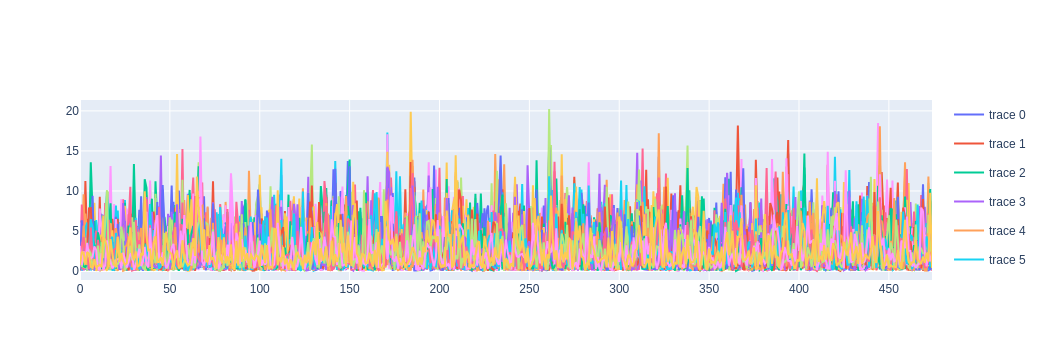

In [43]:
s = evaluate_runner(ncv_q1_many)

fig = go.Figure()
for i in range(s.position_nees.scores.shape[0]):
    fig.add_trace(go.Scatter(x=np.arange(475), y=s.position_nees.scores[i,25:], mode='lines', legendgroup=i))
fig.show()

In [23]:
ex.scatter(y=s.position_nees.scores.mean(axis=1))

In [24]:
means = []
for seed in range(100, 150):
    motion = ConstantVelocityModel(noise_intensity=1)
    kf = LinearKalmanFilter(motion, [[1, 0, 0, 0, 0, 0],
                                     [0, 1, 0, 0, 0, 0],
                                     [0, 0, 1, 0, 0, 0]])
    
    sensor = GeometricSensor(seed=seed)
    r = Runner(target, sensor, kf)
    r.run_one(500)

    r.m = 1
    r.after_many()

    s = evaluate_runner(r)
    means.append(s.position_nees.scores.mean(axis=0))

In [25]:
ex.scatter(y=means)